<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Разработка-метода-кодирования-информации" data-toc-modified-id="Разработка-метода-кодирования-информации-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Разработка метода кодирования информации</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Результаты-и-выводы" data-toc-modified-id="Результаты-и-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Результаты и выводы</a></span></li></ul></div>

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('insurance.csv')

In [3]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [5]:
df.duplicated().sum()

153

In [6]:
df['Страховые выплаты'].value_counts(normalize=True)

0    0.8872
1    0.0846
2    0.0230
3    0.0036
4    0.0014
5    0.0002
Name: Страховые выплаты, dtype: float64

Датафрейм на 5000 объектов, присутствует дисбаланс классов, пропусков нет, признаки необходимо переименовать, признаки `Возраст` и `Зарплата` сохранены в формате `float`, имеется 153 полных дубликата. Напишем функцию для замены типа данных, переименовывания столбцов и удаления дубликатов

In [7]:
def column_float_to_int(data):
    
    for column in data.columns:
        data[column] = data[column].astype('int')
        
    data.columns = ['sex', 'age', 'income', 'family_size', 'insurance']
    
    data = data.drop_duplicates().reset_index(drop=True)
        
    print(data.info(), '\n')
    
    return(data)

In [8]:
df = column_float_to_int(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   sex          4847 non-null   int32
 1   age          4847 non-null   int32
 2   income       4847 non-null   int32
 3   family_size  4847 non-null   int32
 4   insurance    4847 non-null   int32
dtypes: int32(5)
memory usage: 94.8 KB
None 



Проверим признаки на мультиколлинеарность (используем корреляцию Спирмена, которая применима для дискретных переменных)

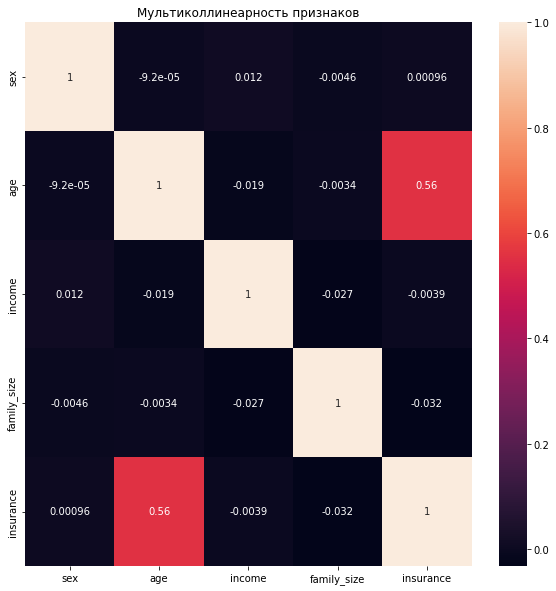

In [9]:
fig = plt.figure(figsize=(10,10))
plt.title('Мультиколлинеарность признаков')

sns.heatmap(df.corr(method='spearman'), annot=True)

fig.show()

Большинство признаков независимы с таргетом (признак `insurance`).   
Посмотрим распределения признаков

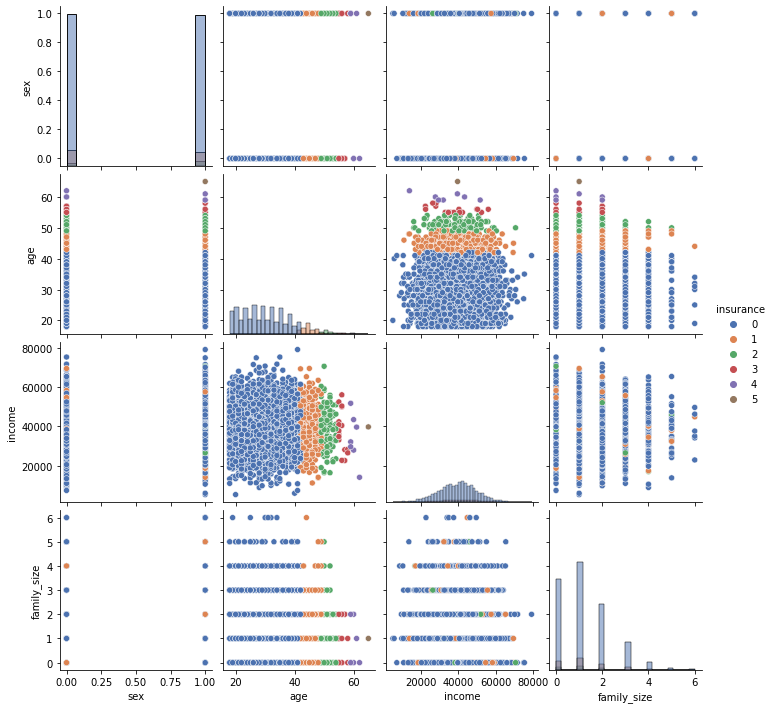

In [10]:
sns.pairplot(data=df, hue='insurance', diag_kind="hist", palette='deep')
plt.show()

На распределении сразу видно, что с возрастом растет количество страховых выплат. Кроме того, количество выплат зависит от размера семьи - с уменьшением количества родственников растет количество выплат

## Разработка метода кодирования информации

Предположим:   
$a_1, a_2$ - предсказаний модели   
$w_1, w_2$ - веса линейной регрессии   
$X$ - матрица признаков, размер m x n   
$P$ - случайная **обратимая** матрица размера n x n   


Тогда предсказания моделей вычисляются по следующим формулам:  
$$
a_1 = X  w 
$$
$$
a_2 = P  X  w'
$$

Рассчитаем формулу весов для каждого предсказания:
$$
w = (X^T X)^{-1} X^T y   
$$
$$
w' = ((P X)^T (P X))^{-1} (P X)^T y  
$$
Подставим в уравнение и преобразуем:  

$$
w' = ((XP)^T XP)^{-1} (XP)^T y
$$

$$
w' = (P^T (X^T X) P)^{-1} (XP)^T y
$$

$$
w' = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y
$$

Cокращаем: 
$$
(P^T)^{-1} P^T = E
$$

$$
w' = P^{-1} (X^T X)^{-1} X^T y
$$

$$
(X^T X)^{-1} X^T y = w, откуда
$$

$$
w' = P^{-1} w
$$


**Вывод:** Умножив матрицы признаков на случайную (но обязательно обратимую) матрицу, предсказания линейной регрессии не изменятся

## Алгоритм преобразования

Для преобразования и кодирования признаков напишем функцию, которая будет создавать обратимую матрицу указанных размеров

In [11]:
'''
Функция принимает 4 параметра: нижнюю границу,
верхнюю границу, размеры квадратной матрицы и 
сид.
Создает и возвращает матрицу заданных размеров и проверяет
ее на вырожденность.
'''

def random_reversible_matrix(low, high, square, random_state):
    matrix = np.random.randint(low=low,
                               high=high,
                               size=(square, square))
    try:
        rev_matrix = np.linalg.inv(matrix)
    except LinAlgError:
        raise LinAlgError('Для заданного random_state матрица вырождена')
    return matrix

Создадим матрицу для кодирования переменных

In [12]:
encode_matrix = random_reversible_matrix(-50, 50, 4, 1)
encode_matrix

array([[ 33,  31,  -1,  19],
       [-49,  30, -16, -10],
       [-15, -15,  31, -47],
       [-45,  17, -22, -23]])

Разобьем датасет на признаки и таргет

In [13]:
X = df.drop('insurance', axis=1)
y = df['insurance']

Закодируем признаки и сохраним в переменную

In [14]:
X_encoded = np.array(X).dot(encode_matrix)

In [15]:
X_encoded.shape, X.shape

((4847, 4), (4847, 4))

Проверим, можем ли мы раскодировать признаки

Напишем алгоритм для расшифровки данных

In [16]:
def decoder(features, features_encoded, enc_matrix):
    
    enc_key = np.linalg.inv(enc_matrix)

    features_dec = pd.DataFrame(data=features_encoded.dot(enc_key),
                              columns=features.columns)
    return features_dec

In [17]:
features_test = decoder(X, X_encoded, encode_matrix)
print(X.mean(), '\n')
print(features_test.mean())

sex                0.498453
age               31.023932
income         39895.811223
family_size        1.203425
dtype: float64 

sex                0.498453
age               31.023932
income         39895.811223
family_size        1.203425
dtype: float64


**Выводы:**   

Мы получили генератор случайных обратимых матриц, с помощью которого закодировали признаки и получили два сета признаков - кодированные и нет.   

Обучим линейную регрессию на каждом сете и сравним метрики. В качестве контрольной метрики выбираем R2

## Проверка алгоритма

In [18]:
'''
Функция принимает признаки и таргет
В теле разбивает признаки на обучающую 
и тестовые выборки, создает модель линейной
регрессии и считает значения R2 на 5 стратифицированных
фолдах. Возвращает выборки и лист скоров
'''
def split_cross_val(features, target):
    
    features_train, features_test, target_train, target_test = train_test_split(features,
                                                                                target,
                                                                               test_size=0.2,
                                                                               random_state=47)
    
    model = LinearRegression()
    cv = KFold(n_splits=5, shuffle=True, random_state=47)
    
    scores = cross_val_score(model, features_train, target_train,
                            scoring='r2', cv=cv, n_jobs=-1)
    
    return features_train, features_test, target_train, target_test, scores

In [19]:
X_train, X_test, y_train, y_test, scores = split_cross_val(X, y)

In [20]:
X_train_enc, X_test_enc, y_train_enc, y_test_enc, scores_enc = split_cross_val(X, y)

In [21]:
assert(scores.mean() == scores_enc.mean())

Кросс-валидация показала, что на обучающей выборке разницы между R2 метрикой нет. Проверим на тестовой выборке

In [22]:
def lin_regr_test(X_train, X_test, y_train, y_test):
    
    model = LinearRegression().fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    score = r2_score(y_test, predictions)
    
    return model, predictions, score

In [23]:
model, predictions, score = lin_regr_test(X_train, X_test, y_train, y_test)
model_enc, predictions_enc, score_enc = lin_regr_test(X_train_enc, X_test_enc, y_train_enc, y_test_enc)

assert(score == score_enc)

print(f'R2-score датасета: {score}')
print(f'R2-score кодированного датасета: {score_enc}')

R2-score датасета: 0.4237137398697042
R2-score кодированного датасета: 0.4237137398697042


## Результаты и выводы

Был проведен исследовательский анализ данных. В результате были удалены дубликаты и переименованы признаки. Анализ распределения и корреляции показал, что большинство признаков линейно независимы с целевым.   

Был создан алгоритм создания случайной обратимой матрицы для кодирования значений признаков (приведены доказательства применимости такой методики). На примере этих данных показано, что значение метрики и предсказаний модели не зависят от кодирования. Данные легко расшифровываются, используя написанный нами алгоритм.   

Теория и алгоритмы были проверены на приведенном датасете. Кросс-валидация и предсказания тестовой выборки показали, что значения метрики не зависят от шифрования.   

**Рекомендации:**   

Базовая модель линейной регрессии слабо показывает себя на таких данных. Для улучшения модели рекомендуется:  
1) Работать с признаками и объектами - добавить новых, так как у нас их достаточно мало   
2) Использовать нелинейную модель - преобразовать функции полиномиальной функцией и обучить модель на них (в таком случае, нужен новый способ защиты данных)      
3) Использовать регуляризацию - L1, L2 или смесь (Лассо, Ридж или ЭластикНет)   
4) Использовать другие модели и/или их ансамбли   
    
Приведенные выше рекомендации с достаточной долей уверенности смогут повысить производительность модели и улучшить предсказания